# S&P 500 Empirical Study: Distribution Comparison

This notebook compares various probability distributions for modeling S&P 500 daily log returns.

## Distributions Compared

1. **Normal** - Baseline Gaussian distribution
2. **Student-t** - Heavy-tailed symmetric distribution
3. **Variance Gamma (VG)** - Normal-Gamma mixture, semi-heavy tails
4. **Normal Inverse Gamma (NInvG)** - Normal-InverseGamma mixture, heavy tails
5. **Normal Inverse Gaussian (NIG)** - Normal-InverseGaussian mixture
6. **Generalized Hyperbolic (GH)** - Most general, encompasses VG, NInvG, NIG as special cases
7. **Stable (Lévy)** - Power-law tails, potentially infinite variance

## Methodology

- **Data**: 10 years of S&P 500 daily returns
- **Training**: First 5 years (in-sample)
- **Testing**: Last 5 years (out-of-sample)
- **Metrics**: KS test, Anderson-Darling test, tail fit analysis, QQ plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.stats import ks_2samp, anderson_ksamp
import warnings
warnings.filterwarnings('ignore')

# Import normix distributions
from normix.distributions.mixtures import (
    VarianceGamma, NormalInverseGamma, NormalInverseGaussian, GeneralizedHyperbolic
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Imports successful!")

Imports successful!


## 1. Download and Prepare S&P 500 Data

In [2]:
import yfinance as yf
from datetime import datetime, timedelta

# Download 10 years of S&P 500 data
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10 + 30)  # Extra buffer for trading days

print(f"Downloading S&P 500 data from {start_date.date()} to {end_date.date()}...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

print(f"Downloaded {len(sp500)} trading days")
print(f"Date range: {sp500.index[0].date()} to {sp500.index[-1].date()}")

Downloaded 2534 trading days
Date range: 2016-01-04 to 2026-01-30


In [3]:
# Compute log returns
sp500['Log_Return'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500 = sp500.dropna()

# Split into training (first 5 years) and testing (last 5 years)
n_total = len(sp500)
n_train = n_total // 2

train_data = sp500.iloc[:n_train]
test_data = sp500.iloc[n_train:]

# Extract log returns as numpy arrays
returns_train = train_data['Log_Return'].values
returns_test = test_data['Log_Return'].values

print(f"\nTraining period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Training samples: {len(returns_train)}")
print(f"\nTesting period: {test_data.index[0].date()} to {test_data.index[-1].date()}")
print(f"Testing samples: {len(returns_test)}")

print(f"\n--- Training Data Statistics ---")
print(f"Mean: {returns_train.mean()*100:.4f}%")
print(f"Std:  {returns_train.std()*100:.4f}%")
print(f"Skewness: {stats.skew(returns_train):.4f}")
print(f"Kurtosis: {stats.kurtosis(returns_train):.4f} (excess)")
print(f"Min:  {returns_train.min()*100:.4f}%")
print(f"Max:  {returns_train.max()*100:.4f}%")


Training period: 2016-01-05 to 2021-01-13
Training samples: 1266

Testing period: 2021-01-14 to 2026-01-30
Testing samples: 1267

--- Training Data Statistics ---
Mean: 0.0504%
Std:  1.2153%
Skewness: -1.1383
Kurtosis: 22.0201 (excess)
Min:  -12.7652%
Max:  8.9683%


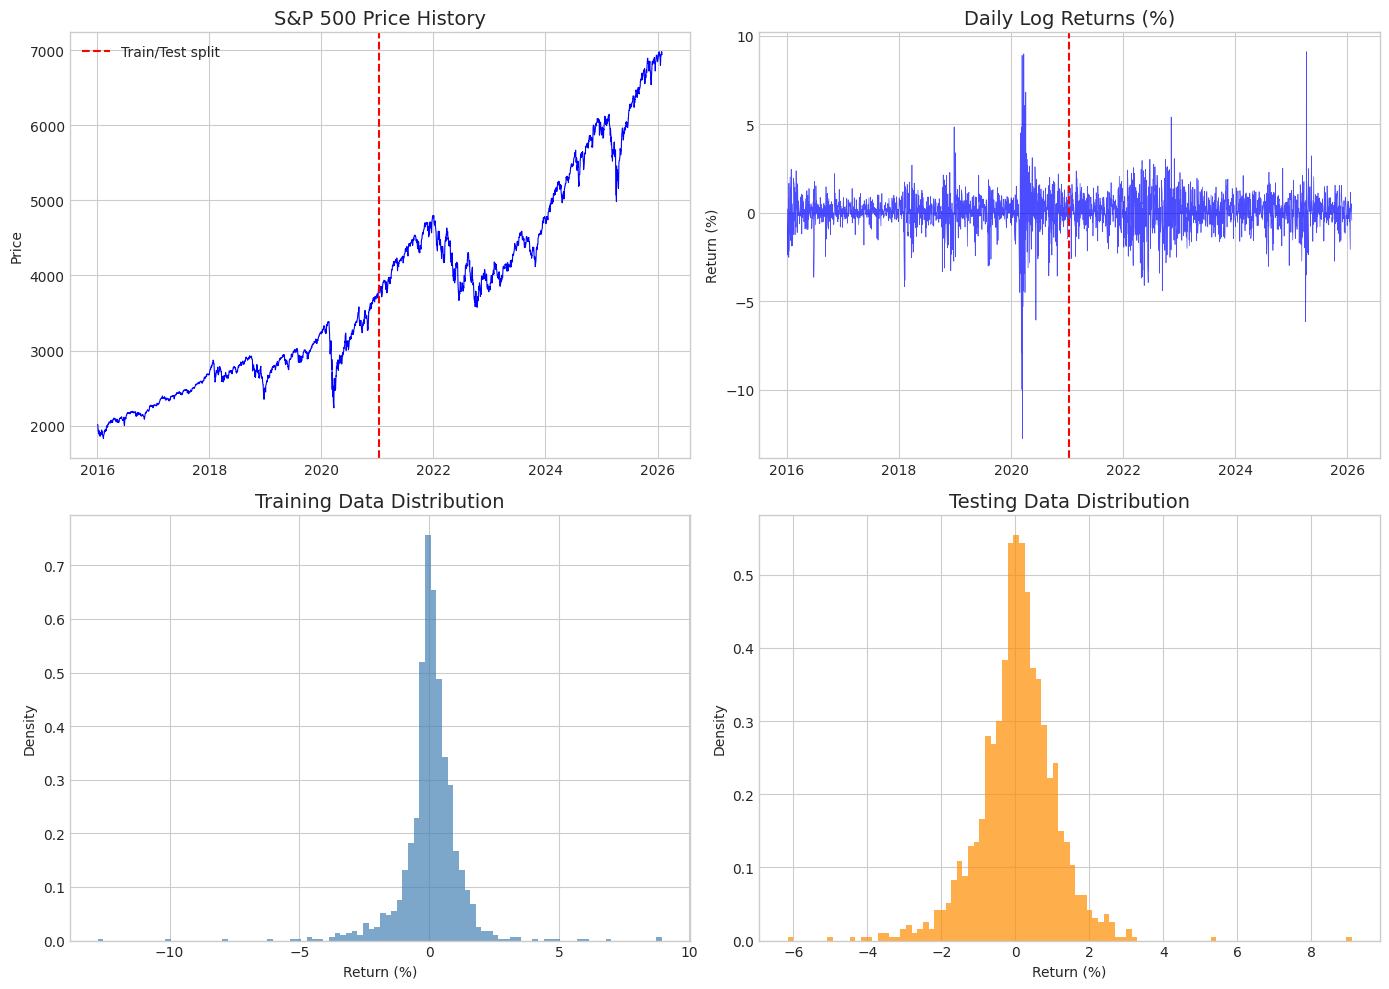

In [4]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price history
axes[0, 0].plot(sp500.index, sp500['Close'], 'b-', linewidth=0.8)
axes[0, 0].axvline(train_data.index[-1], color='red', linestyle='--', label='Train/Test split')
axes[0, 0].set_title('S&P 500 Price History', fontsize=14)
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()

# Returns time series
axes[0, 1].plot(sp500.index, sp500['Log_Return']*100, 'b-', linewidth=0.5, alpha=0.7)
axes[0, 1].axvline(train_data.index[-1], color='red', linestyle='--')
axes[0, 1].set_title('Daily Log Returns (%)', fontsize=14)
axes[0, 1].set_ylabel('Return (%)')

# Training histogram
axes[1, 0].hist(returns_train*100, bins=100, density=True, alpha=0.7, color='steelblue')
axes[1, 0].set_title('Training Data Distribution', fontsize=14)
axes[1, 0].set_xlabel('Return (%)')
axes[1, 0].set_ylabel('Density')

# Testing histogram
axes[1, 1].hist(returns_test*100, bins=100, density=True, alpha=0.7, color='darkorange')
axes[1, 1].set_title('Testing Data Distribution', fontsize=14)
axes[1, 1].set_xlabel('Return (%)')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

## 2. Fit Distributions to Training Data

We fit each distribution using Maximum Likelihood Estimation (MLE).

In [5]:
# Reshape for normix (expects 2D input)
X_train = returns_train.reshape(-1, 1)
X_test = returns_test.reshape(-1, 1)

# Dictionary to store fitted distributions
fitted_dists = {}

print("Fitting distributions to training data...\n")

Fitting distributions to training data...



In [6]:
# 1. Normal distribution
print("1. Fitting Normal distribution...")
mu_norm, std_norm = stats.norm.fit(returns_train)
fitted_dists['Normal'] = stats.norm(loc=mu_norm, scale=std_norm)
print(f"   μ = {mu_norm:.6f}, σ = {std_norm:.6f}")

1. Fitting Normal distribution...
   μ = 0.000504, σ = 0.012153


In [7]:
# 2. Student-t distribution
print("2. Fitting Student-t distribution...")
df_t, loc_t, scale_t = stats.t.fit(returns_train)
fitted_dists['Student-t'] = stats.t(df=df_t, loc=loc_t, scale=scale_t)
print(f"   df = {df_t:.4f}, loc = {loc_t:.6f}, scale = {scale_t:.6f}")

2. Fitting Student-t distribution...
   df = 1.9380, loc = 0.001003, scale = 0.005116


In [8]:
# 3. Variance Gamma
print("3. Fitting Variance Gamma distribution (EM algorithm)...")
vg = VarianceGamma()
vg.fit(X_train, max_iter=100, tol=1e-6, verbose=0)
fitted_dists['Variance Gamma'] = vg
vg_params = vg.get_classical_params()
print(f"   μ = {vg_params['mu'][0]:.6f}, γ = {vg_params['gamma'][0]:.6f}")
print(f"   σ² = {vg_params['sigma'][0,0]:.8f}, α = {vg_params['shape']:.4f}, β = {vg_params['rate']:.4f}")

3. Fitting Variance Gamma distribution (EM algorithm)...
   μ = 0.001563, γ = -0.000541
   σ² = 0.00005606, α = 0.6807, β = 0.3478


In [9]:
# 4. Normal Inverse Gamma
print("4. Fitting Normal Inverse Gamma distribution (EM algorithm)...")
ninvg = NormalInverseGamma()
ninvg.fit(X_train, max_iter=100, tol=1e-6, verbose=0)
fitted_dists['Normal Inv Gamma'] = ninvg
ninvg_params = ninvg.get_classical_params()
print(f"   μ = {ninvg_params['mu'][0]:.6f}, γ = {ninvg_params['gamma'][0]:.6f}")
print(f"   σ² = {ninvg_params['sigma'][0,0]:.8f}, α = {ninvg_params['shape']:.4f}, β = {ninvg_params['rate']:.4f}")

4. Fitting Normal Inverse Gamma distribution (EM algorithm)...
   μ = 0.001443, γ = -0.000979
   σ² = 0.00012467, α = 1.5000, β = 0.4244


In [10]:
# 5. Normal Inverse Gaussian
print("5. Fitting Normal Inverse Gaussian distribution (EM algorithm)...")
nig = NormalInverseGaussian()
nig.fit(X_train, max_iter=100, tol=1e-6, verbose=0)
fitted_dists['Normal Inv Gaussian'] = nig
nig_params = nig.get_classical_params()
print(f"   μ = {nig_params['mu'][0]:.6f}, γ = {nig_params['gamma'][0]:.6f}")
print(f"   σ² = {nig_params['sigma'][0,0]:.8f}, δ = {nig_params['delta']:.6f}, η = {nig_params['eta']:.6f}")

5. Fitting Normal Inverse Gaussian distribution (EM algorithm)...
   μ = 0.001087, γ = -0.000312
   σ² = 0.00007323, δ = 1.869184, η = 0.343997


In [11]:
# 6. Generalized Hyperbolic
print("6. Fitting Generalized Hyperbolic distribution (EM algorithm)...")
gh = GeneralizedHyperbolic()
# Use fix_p regularization with p=-0.5 (NIG-like) for stability on return data
gh.fit(X_train, max_iter=100, tol=1e-4, verbose=0, 
       regularization='fix_p', regularization_params={'p_fixed': -0.5})
fitted_dists['Gen. Hyperbolic'] = gh
gh_params = gh.get_classical_params()
print(f"   μ = {gh_params['mu'][0]:.6f}, γ = {gh_params['gamma'][0]:.6f}")
print(f"   σ² = {gh_params['sigma'][0,0]:.8f}")
print(f"   p = {gh_params['p']:.4f}, a = {gh_params['a']:.4f}, b = {gh_params['b']:.4f}")

6. Fitting Generalized Hyperbolic distribution (EM algorithm)...
   μ = 0.001111, γ = -0.000060
   σ² = 0.00001362
   p = -0.5000, a = 0.0172, b = 1.9940


In [12]:
# 7. Stable (Lévy) distribution
print("7. Fitting Stable (Lévy) distribution...")
print("   (This may take a while...)")
alpha_s, beta_s, loc_s, scale_s = stats.levy_stable.fit(returns_train)
fitted_dists['Stable'] = stats.levy_stable(alpha=alpha_s, beta=beta_s, loc=loc_s, scale=scale_s)
print(f"   α = {alpha_s:.4f}, β = {beta_s:.4f}, loc = {loc_s:.6f}, scale = {scale_s:.6f}")

print("\nAll distributions fitted!")

7. Fitting Stable (Lévy) distribution...
   (This may take a while...)
   α = 1.3805, β = -0.0567, loc = 0.000780, scale = 0.004423

All distributions fitted!


## 3. In-Sample Comparison (Training Data)

In [13]:
def get_pdf_values(dist, x, dist_name):
    """Get PDF values for a distribution (handles both scipy and normix)."""
    if dist_name in ['Normal', 'Student-t', 'Stable']:
        return dist.pdf(x)
    else:
        # normix distributions expect 2D input
        return dist.pdf(x.reshape(-1, 1)).flatten()

def generate_samples(dist, n_samples, dist_name, random_state=42):
    """Generate samples from a distribution."""
    if dist_name in ['Normal', 'Student-t', 'Stable']:
        return dist.rvs(size=n_samples, random_state=random_state)
    else:
        return dist.rvs(size=n_samples, random_state=random_state).flatten()

In [14]:
# Define x range for PDF plotting
x_range = np.linspace(returns_train.min() * 1.2, returns_train.max() * 1.2, 500)

# Colors for each distribution
colors = {
    'Normal': 'blue',
    'Student-t': 'red',
    'Variance Gamma': 'green',
    'Normal Inv Gamma': 'purple',
    'Normal Inv Gaussian': 'orange',
    'Gen. Hyperbolic': 'brown',
    'Stable': 'cyan'
}

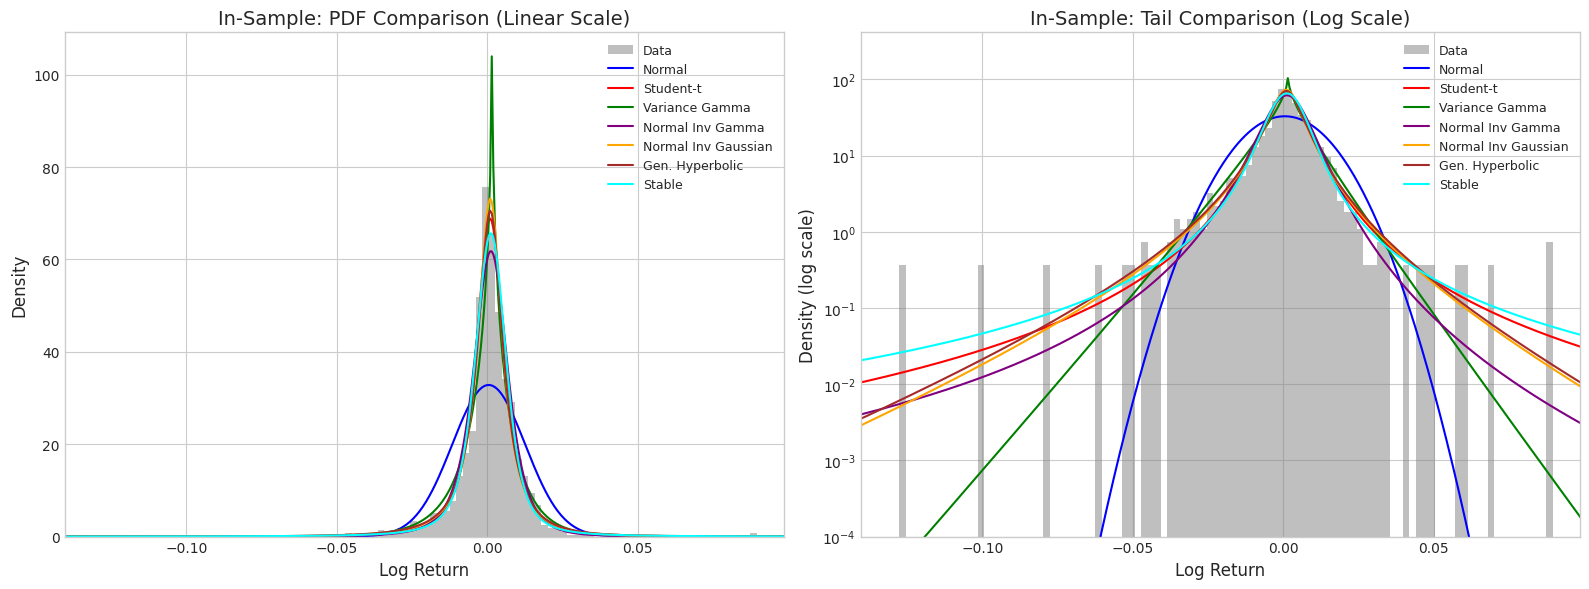

In [15]:
# Plot all distributions against training data histogram
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale
axes[0].hist(returns_train, bins=100, density=True, alpha=0.5, color='gray', label='Data')
for name, dist in fitted_dists.items():
    pdf_vals = get_pdf_values(dist, x_range, name)
    axes[0].plot(x_range, pdf_vals, color=colors[name], linewidth=1.5, label=name)

axes[0].set_xlabel('Log Return', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('In-Sample: PDF Comparison (Linear Scale)', fontsize=14)
axes[0].legend(loc='upper right', fontsize=9)
axes[0].set_xlim(returns_train.min() * 1.1, returns_train.max() * 1.1)

# Log scale for tail comparison
axes[1].hist(returns_train, bins=100, density=True, alpha=0.5, color='gray', label='Data')
for name, dist in fitted_dists.items():
    pdf_vals = get_pdf_values(dist, x_range, name)
    pdf_vals = np.clip(pdf_vals, 1e-10, None)  # Avoid log(0)
    axes[1].semilogy(x_range, pdf_vals, color=colors[name], linewidth=1.5, label=name)

axes[1].set_xlabel('Log Return', fontsize=12)
axes[1].set_ylabel('Density (log scale)', fontsize=12)
axes[1].set_title('In-Sample: Tail Comparison (Log Scale)', fontsize=14)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].set_xlim(returns_train.min() * 1.1, returns_train.max() * 1.1)
axes[1].set_ylim(1e-4, None)

plt.tight_layout()
plt.show()

## 4. Out-of-Sample Comparison (Testing Data)

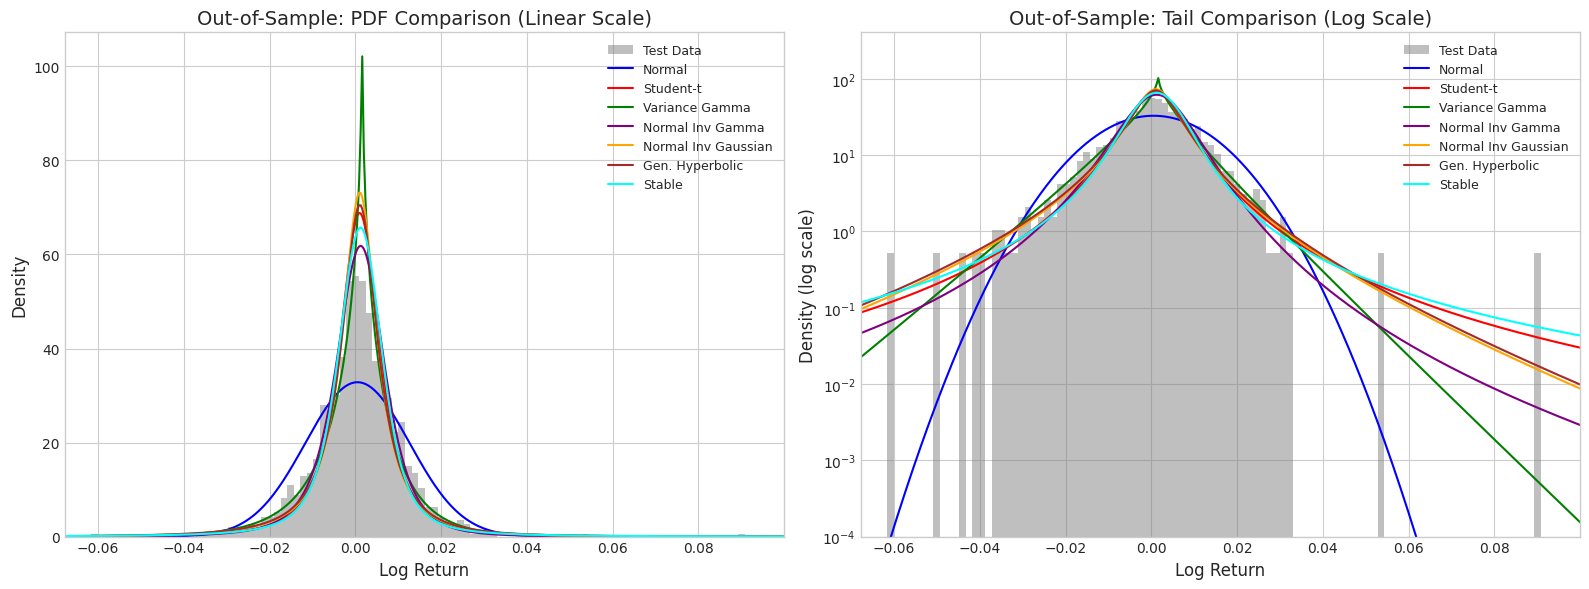

In [16]:
# Plot all distributions against testing data histogram
x_range_test = np.linspace(returns_test.min() * 1.2, returns_test.max() * 1.2, 500)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale
axes[0].hist(returns_test, bins=100, density=True, alpha=0.5, color='gray', label='Test Data')
for name, dist in fitted_dists.items():
    pdf_vals = get_pdf_values(dist, x_range_test, name)
    axes[0].plot(x_range_test, pdf_vals, color=colors[name], linewidth=1.5, label=name)

axes[0].set_xlabel('Log Return', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Out-of-Sample: PDF Comparison (Linear Scale)', fontsize=14)
axes[0].legend(loc='upper right', fontsize=9)
axes[0].set_xlim(returns_test.min() * 1.1, returns_test.max() * 1.1)

# Log scale for tail comparison
axes[1].hist(returns_test, bins=100, density=True, alpha=0.5, color='gray', label='Test Data')
for name, dist in fitted_dists.items():
    pdf_vals = get_pdf_values(dist, x_range_test, name)
    pdf_vals = np.clip(pdf_vals, 1e-10, None)
    axes[1].semilogy(x_range_test, pdf_vals, color=colors[name], linewidth=1.5, label=name)

axes[1].set_xlabel('Log Return', fontsize=12)
axes[1].set_ylabel('Density (log scale)', fontsize=12)
axes[1].set_title('Out-of-Sample: Tail Comparison (Log Scale)', fontsize=14)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].set_xlim(returns_test.min() * 1.1, returns_test.max() * 1.1)
axes[1].set_ylim(1e-4, None)

plt.tight_layout()
plt.show()

## 5. Statistical Tests

### 5.1 Kolmogorov-Smirnov Test (Two-Sample)

We compare samples generated from each fitted distribution against the actual data.

In [24]:
# Generate samples from each distribution for testing
n_sim = 100000

print("Kolmogorov-Smirnov Two-Sample Test")
print("="*70)
print(f"{'Distribution':<20} {'In-Sample KS':<15} {'p-value':<12} {'Out-Sample KS':<15} {'p-value':<12}")
print("-"*70)

ks_results = {}

for name, dist in fitted_dists.items():
    # Generate samples from fitted distribution
    sim_samples = generate_samples(dist, n_sim, name)
    
    # In-sample test
    ks_in, pval_in = ks_2samp(returns_train, sim_samples)
    
    # Out-of-sample test
    ks_out, pval_out = ks_2samp(returns_test, sim_samples)
    
    ks_results[name] = {
        'ks_in': ks_in, 'pval_in': pval_in,
        'ks_out': ks_out, 'pval_out': pval_out
    }
    
    print(f"{name:<20} {ks_in:<15.4f} {pval_in:<12.4f} {ks_out:<15.4f} {pval_out:<12.4f}")

print("\nNote: Lower KS statistic = better fit. p-value > 0.05 suggests distributions are similar.")

Kolmogorov-Smirnov Two-Sample Test
Distribution         In-Sample KS    p-value      Out-Sample KS   p-value     
----------------------------------------------------------------------
Normal               0.1553          0.0000       0.0902          0.0000      
Student-t            0.0280          0.2767       0.0620          0.0001      
Variance Gamma       0.0438          0.0161       0.0484          0.0056      
Normal Inv Gamma     0.0396          0.0385       0.0500          0.0037      
Normal Inv Gaussian  0.0282          0.2671       0.0580          0.0004      
Gen. Hyperbolic      0.0320          0.1520       0.0505          0.0033      
Stable               0.0358          0.0786       0.0585          0.0004      

Note: Lower KS statistic = better fit. p-value > 0.05 suggests distributions are similar.


### 5.2 Anderson-Darling Test (Two-Sample)

The Anderson-Darling test is more sensitive to the tails than KS.

In [25]:
print("Anderson-Darling Two-Sample Test")
print("="*70)
print(f"{'Distribution':<20} {'In-Sample AD':<15} {'Out-Sample AD':<15} {'Critical 5%':<15}")
print("-"*70)

ad_results = {}

for name, dist in fitted_dists.items():
    # Generate samples from fitted distribution
    sim_samples = generate_samples(dist, n_sim, name)
    
    # In-sample test
    ad_in = anderson_ksamp([returns_train, sim_samples])
    
    # Out-of-sample test  
    ad_out = anderson_ksamp([returns_test, sim_samples])
    
    ad_results[name] = {
        'ad_in': ad_in.statistic, 'ad_out': ad_out.statistic,
        'critical': ad_in.critical_values[2]  # 5% significance level
    }
    
    print(f"{name:<20} {ad_in.statistic:<15.4f} {ad_out.statistic:<15.4f} {ad_in.critical_values[2]:<15.4f}")

print("\nNote: Lower AD statistic = better fit. Statistic < Critical value suggests good fit.")

Anderson-Darling Two-Sample Test
Distribution         In-Sample AD    Out-Sample AD   Critical 5%    
----------------------------------------------------------------------
Normal               70.4915         31.3114         1.9610         
Student-t            0.3055          12.2013         1.9610         
Variance Gamma       2.8422          4.5247          1.9610         
Normal Inv Gamma     2.3950          8.5679          1.9610         
Normal Inv Gaussian  0.2346          11.2279         1.9610         
Gen. Hyperbolic      0.4461          7.6167          1.9610         
Stable               0.8435          11.5218         1.9610         

Note: Lower AD statistic = better fit. Statistic < Critical value suggests good fit.


## 6. Tail Analysis

### 6.1 Empirical vs Fitted Tail Probabilities

In [26]:
def get_cdf_values(dist, x, dist_name):
    """Get CDF values for a distribution."""
    if dist_name in ['Normal', 'Student-t', 'Stable']:
        return dist.cdf(x)
    else:
        # For normix, compute CDF by numerical integration or use empirical
        samples = generate_samples(dist, 50000, dist_name, random_state=123)
        return np.array([np.mean(samples <= xi) for xi in x])

# Compute tail probabilities at various quantiles
tail_quantiles = [0.01, 0.025, 0.05, 0.95, 0.975, 0.99]

print("Tail Probability Comparison (Out-of-Sample)")
print("="*90)
print(f"{'Quantile':<10}", end="")
print(f"{'Empirical':<12}", end="")
for name in fitted_dists.keys():
    print(f"{name[:10]:<12}", end="")
print()
print("-"*90)

# Compute empirical quantiles from test data
empirical_quantiles = np.quantile(returns_test, tail_quantiles)

for i, q in enumerate(tail_quantiles):
    emp_val = empirical_quantiles[i]
    print(f"{q:<10.3f}", end="")
    print(f"{emp_val:<12.6f}", end="")
    
    for name, dist in fitted_dists.items():
        if name in ['Normal', 'Student-t', 'Stable']:
            fitted_val = dist.ppf(q)
        else:
            # Use simulation for normix distributions
            samples = generate_samples(dist, 50000, name, random_state=456)
            fitted_val = np.quantile(samples, q)
        print(f"{fitted_val:<12.6f}", end="")
    print()

Tail Probability Comparison (Out-of-Sample)
Quantile  Empirical   Normal      Student-t   Variance G  Normal Inv  Normal Inv  Gen. Hyper  Stable      
------------------------------------------------------------------------------------------
0.010     -0.029945   -0.027768   -0.036223   -0.031626   -0.029195   -0.038774   -0.039196   -0.045511   
0.025     -0.021650   -0.023315   -0.021699   -0.023682   -0.019537   -0.024734   -0.025667   -0.023826   
0.050     -0.016600   -0.019486   -0.014268   -0.017459   -0.013924   -0.016607   -0.017305   -0.014696   
0.950     0.016101    0.020494    0.016274    0.016618    0.014089    0.016074    0.016529    0.015768    
0.975     0.020338    0.024323    0.023706    0.021957    0.018088    0.023118    0.023480    0.024060    
0.990     0.025115    0.028776    0.038229    0.029228    0.024963    0.033276    0.034941    0.043895    


### 6.2 QQ Plots

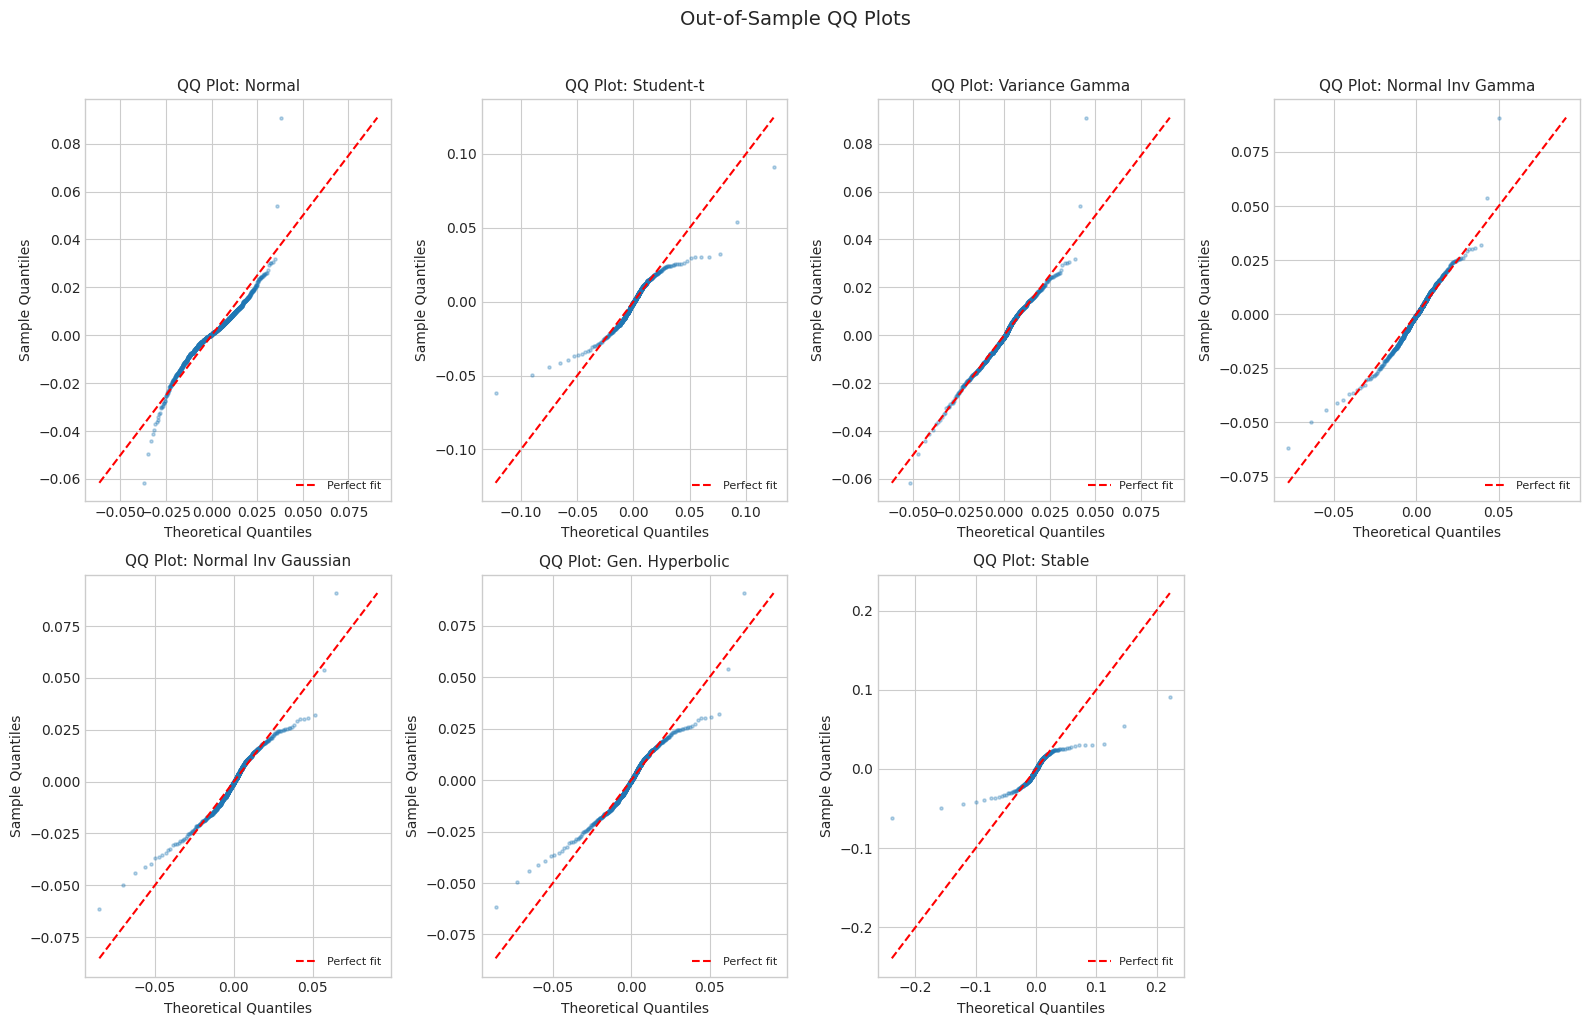

In [27]:
def make_qq_plot(ax, data, dist, dist_name, title):
    """Create QQ plot comparing data to fitted distribution."""
    n = len(data)
    sorted_data = np.sort(data)
    theoretical_quantiles = np.linspace(0.001, 0.999, n)
    
    if dist_name in ['Normal', 'Student-t', 'Stable']:
        theoretical_values = dist.ppf(theoretical_quantiles)
    else:
        # Use simulation for normix
        samples = generate_samples(dist, 50000, dist_name, random_state=789)
        theoretical_values = np.quantile(samples, theoretical_quantiles)
    
    ax.scatter(theoretical_values, sorted_data, alpha=0.3, s=5)
    
    # Add 45-degree line
    lims = [min(theoretical_values.min(), sorted_data.min()),
            max(theoretical_values.max(), sorted_data.max())]
    ax.plot(lims, lims, 'r--', linewidth=1.5, label='Perfect fit')
    
    ax.set_xlabel('Theoretical Quantiles', fontsize=10)
    ax.set_ylabel('Sample Quantiles', fontsize=10)
    ax.set_title(title, fontsize=11)
    ax.legend(loc='lower right', fontsize=8)

# Create QQ plots for out-of-sample data
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, (name, dist) in enumerate(fitted_dists.items()):
    make_qq_plot(axes[i], returns_test, dist, name, f'QQ Plot: {name}')

# Hide empty subplot
axes[-1].axis('off')

plt.suptitle('Out-of-Sample QQ Plots', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 6.3 Tail Index Estimation (Hill Estimator)

The Hill estimator estimates the tail index $\alpha$ for heavy-tailed distributions.
For data with power-law tails: $P(X > x) \sim x^{-\alpha}$

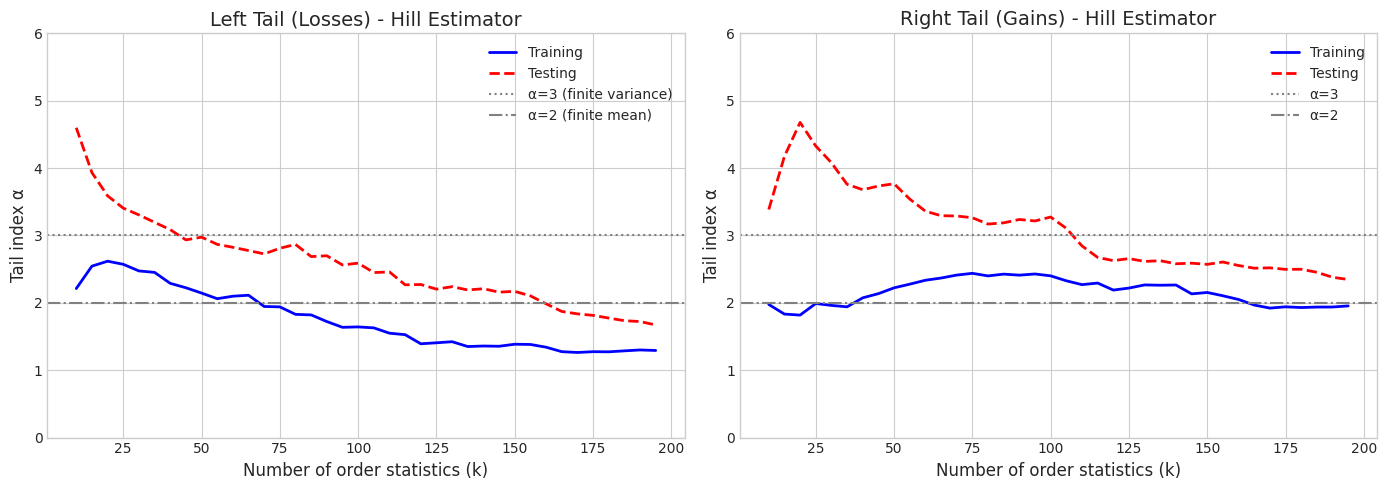


Hill Tail Index Estimates (k=50):
  Left tail (losses):  Train=2.145, Test=2.975
  Right tail (gains):  Train=2.222, Test=3.768


In [28]:
def hill_estimator(data, k):
    """Hill estimator for tail index using top k order statistics."""
    sorted_data = np.sort(np.abs(data))[::-1]  # Sort descending by absolute value
    if k >= len(data) or k < 1:
        return np.nan
    
    log_ratios = np.log(sorted_data[:k]) - np.log(sorted_data[k])
    return k / np.sum(log_ratios)

# Compute Hill estimator for different k values
k_values = np.arange(10, 200, 5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left tail (negative returns)
left_tail_train = -returns_train[returns_train < 0]
left_tail_test = -returns_test[returns_test < 0]

hill_left_train = [hill_estimator(left_tail_train, k) for k in k_values]
hill_left_test = [hill_estimator(left_tail_test, k) for k in k_values]

axes[0].plot(k_values, hill_left_train, 'b-', linewidth=2, label='Training')
axes[0].plot(k_values, hill_left_test, 'r--', linewidth=2, label='Testing')
axes[0].axhline(y=3, color='gray', linestyle=':', label='α=3 (finite variance)')
axes[0].axhline(y=2, color='gray', linestyle='-.', label='α=2 (finite mean)')
axes[0].set_xlabel('Number of order statistics (k)', fontsize=12)
axes[0].set_ylabel('Tail index α', fontsize=12)
axes[0].set_title('Left Tail (Losses) - Hill Estimator', fontsize=14)
axes[0].legend()
axes[0].set_ylim(0, 6)

# Right tail (positive returns)
right_tail_train = returns_train[returns_train > 0]
right_tail_test = returns_test[returns_test > 0]

hill_right_train = [hill_estimator(right_tail_train, k) for k in k_values]
hill_right_test = [hill_estimator(right_tail_test, k) for k in k_values]

axes[1].plot(k_values, hill_right_train, 'b-', linewidth=2, label='Training')
axes[1].plot(k_values, hill_right_test, 'r--', linewidth=2, label='Testing')
axes[1].axhline(y=3, color='gray', linestyle=':', label='α=3')
axes[1].axhline(y=2, color='gray', linestyle='-.', label='α=2')
axes[1].set_xlabel('Number of order statistics (k)', fontsize=12)
axes[1].set_ylabel('Tail index α', fontsize=12)
axes[1].set_title('Right Tail (Gains) - Hill Estimator', fontsize=14)
axes[1].legend()
axes[1].set_ylim(0, 6)

plt.tight_layout()
plt.show()

# Estimate stable tail index (using k=50)
k_stable = 50
print(f"\nHill Tail Index Estimates (k={k_stable}):")
print(f"  Left tail (losses):  Train={hill_estimator(left_tail_train, k_stable):.3f}, Test={hill_estimator(left_tail_test, k_stable):.3f}")
print(f"  Right tail (gains):  Train={hill_estimator(right_tail_train, k_stable):.3f}, Test={hill_estimator(right_tail_test, k_stable):.3f}")

## 7. Value at Risk (VaR) Backtesting

In [29]:
def compute_var(dist, alpha, dist_name):
    """Compute Value at Risk at level alpha."""
    if dist_name in ['Normal', 'Student-t', 'Stable']:
        return dist.ppf(alpha)
    else:
        samples = generate_samples(dist, 100000, dist_name, random_state=999)
        return np.quantile(samples, alpha)

# VaR levels to test
var_levels = [0.01, 0.025, 0.05]

print("Value at Risk Backtesting (Out-of-Sample)")
print("="*80)

for alpha in var_levels:
    print(f"\nVaR at {alpha*100:.1f}% level (Expected exceedances: {alpha*100:.1f}%)")
    print("-"*60)
    print(f"{'Distribution':<20} {'VaR':<15} {'Exceedances':<15} {'Rate (%)':<12}")
    print("-"*60)
    
    for name, dist in fitted_dists.items():
        var = compute_var(dist, alpha, name)
        exceedances = np.sum(returns_test < var)
        rate = exceedances / len(returns_test) * 100
        
        print(f"{name:<20} {var:<15.6f} {exceedances:<15d} {rate:<12.2f}")

Value at Risk Backtesting (Out-of-Sample)

VaR at 1.0% level (Expected exceedances: 1.0%)
------------------------------------------------------------
Distribution         VaR             Exceedances     Rate (%)    
------------------------------------------------------------
Normal               -0.027768       18              1.42        
Student-t            -0.036223       7               0.55        
Variance Gamma       -0.031309       11              0.87        
Normal Inv Gamma     -0.029329       15              1.18        
Normal Inv Gaussian  -0.038405       5               0.39        
Gen. Hyperbolic      -0.039594       4               0.32        
Stable               -0.045511       2               0.16        

VaR at 2.5% level (Expected exceedances: 2.5%)
------------------------------------------------------------
Distribution         VaR             Exceedances     Rate (%)    
------------------------------------------------------------
Normal               -0.